In [1]:
import os
import torch
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from itertools import product
import json
from collections import defaultdict
import random

from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torchvision import models
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from torchviz import make_dot


%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from fastai import transforms, model, dataset, conv_learner

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

torch.set_printoptions(precision=3)

from SSD_model import get_SSD_model
from VOC_data import VOC_dataset
from draw_img_utils import *
from SSDloss import *
from Config import Config

torch.set_printoptions(precision=3)

config = Config('remote')

# PATH = '/home/kindeqi/PyTorch_SSD/dataset/VOCdevkit/VOC2007'
# trn_anno_path = '/home/kindeqi/PyTorch_SSD/annotation/PASCAL_VOC/pascal_train2007.json'
# val_anno_path = '/home/kindeqi/PyTorch_SSD/annotation/PASCAL_VOC/pascal_val2007.json'

train_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno)
batch_size = config.batch_size
learning_rate = config.learning_rate

num_iter = 3

In [5]:
def detection_collate_fn(batch):
    imgs, bboxes, labels = [], [], []
    for i, b, l in batch:
        imgs.append(i); bboxes.append(b); labels.append(l)
    return torch.stack(imgs), bboxes, labels

trn_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=detection_collate_fn)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = get_SSD_model(config.batch_size, config.vgg_weight_path, config.vgg_reduced_weight_path)

# the freeze part is really important, unless you could never train a network
model.freeze_basenet()
model = model.to(device)

# optimizer = torch.optim.SGD(params = model.parameters(), lr=1e-4, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
prior_box = get_prior_box()

loss_array = []


for _ in range(num_iter):
    
    for i, batch in enumerate(trn_dataloader):
        
#         just the first 10 batch
        if i >= 60:
            continue
        
        imgs, bboxes, labels = batch
        imgs = imgs.to(device)
        cls_preds, loc_preds = model(imgs)

        model.zero_grad()

        total_loss = 0
        total_loc_loss, total_cls_loss = 0, 0

        for idx in range(imgs.shape[0]):

            img, bbox, label = imgs[idx], bboxes[idx], labels[idx]
            cls_pred, loc_pred = cls_preds[idx], loc_preds[idx]

            # img, bbox, label = tmp
            # img, bbox, label = train_dataset[0]

            # img = img.unsqueeze(0)

            # cls_pred, loc_pred = model(img)
            # cls_pred, loc_pred = cls_pred.squeeze(0), loc_pred.squeeze(0)

            # PATH = 'C:\\datasets\\pascal\\'
            # anno_path = f'{PATH}PASCAL_VOC\\pascal_train2007.json'
            # train_dataset = VOC_dataset(PATH, anno_path)

            # img, bbox, label = train_dataset[7]
            # img = img.unsqueeze(0)

#             prior_box = get_prior_box()
            iou = get_iou(bbox, prior_box)

            pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)
            pos_mask, cls_target, bbox_target = pos_mask.to(device), cls_target.to(device), bbox_target.to(device)

            # model = get_SSD_model(1)
            # cls_pred, loc_pred = model(img)
            # cls_pred, loc_pred = cls_pred.squeeze(0), loc_pred.squeeze(0)

            loss_loc, loss_cls = loss(cls_pred, loc_pred, pos_mask, cls_target, bbox_target)
            total_loc_loss += loss_loc; total_cls_loss += loss_cls

#             total_loss += (loss_loc + loss_cls)
            total_loss += loss_cls

        total_loss /= float(imgs.shape[0])
        total_cls_loss /= float(imgs.shape[0])
        total_loc_loss /= float(imgs.shape[0])
        
        total_loss.backward()

        optimizer.step()
#         if i % 10 == 0:
        cls_loss = round(float(total_cls_loss), 3)
        loc_loss = round(float(total_loc_loss), 3)
        t_loss = round(float(total_loss), 3)

        print(i, 'cls_loss: {}, loc_loss: {}, loss: {}'.format(cls_loss, loc_loss, t_loss))
        loss_array.append(t_loss)
        
#         if i == 20:
#             torch.save(model.state_dict(), '20.pth')
        
#         if i == 50:
#             torch.save(model.state_dict(), '50.pth')
            
#         if i == 100:
#             torch.save(model.state_dict(), '100.pth')


/home/kindeqi/PyTorch_SSD/SSD_model.py:141: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
/home/kindeqi/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0 cls_loss: 3.426, loc_loss: 4.712, loss: 3.426
1 cls_loss: 5.519, loc_loss: 6.079, loss: 5.519
2 cls_loss: 5.292, loc_loss: 4.456, loss: 5.292
3 cls_loss: 4.992, loc_loss: 4.542, loss: 4.992
4 cls_loss: 3.504, loc_loss: 4.844, loss: 3.504
5 cls_loss: 3.343, loc_loss: 4.571, loss: 3.343
6 cls_loss: 3.169, loc_loss: 4.313, loss: 3.169
7 cls_loss: 3.6, loc_loss: 6.65, loss: 3.6
8 cls_loss: 2.991, loc_loss: 5.146, loss: 2.991
9 cls_loss: 3.67, loc_loss: 6.26, loss: 3.67
10 cls_loss: 3.405, loc_loss: 4.51, loss: 3.405
11 cls_loss: 3.49, loc_loss: 5.51, loss: 3.49
12 cls_loss: 2.977, loc_loss: 4.643, loss: 2.977
13 cls_loss: 3.384, loc_loss: 6.107, loss: 3.384
14 cls_loss: 3.38, loc_loss: 5.21, loss: 3.38
15 cls_loss: 3.035, loc_loss: 6.305, loss: 3.035
16 cls_loss: 3.003, loc_loss: 5.174, loss: 3.003
17 cls_loss: 2.953, loc_loss: 4.277, loss: 2.953
18 cls_loss: 2.752, loc_loss: 4.606, loss: 2.752
19 cls_loss: 2.711, loc_loss: 6.134, loss: 2.711
20 cls_loss: 2.754, loc_loss: 5.397, loss: 2.

50 cls_loss: 1.675, loc_loss: 4.674, loss: 1.675
51 cls_loss: 1.652, loc_loss: 4.929, loss: 1.652
52 cls_loss: 1.791, loc_loss: 4.274, loss: 1.791
53 cls_loss: 1.843, loc_loss: 4.761, loss: 1.843
54 cls_loss: 1.72, loc_loss: 4.017, loss: 1.72
55 cls_loss: 1.622, loc_loss: 3.927, loss: 1.622
56 cls_loss: 1.613, loc_loss: 4.001, loss: 1.613
57 cls_loss: 1.304, loc_loss: 6.333, loss: 1.304
58 cls_loss: 1.48, loc_loss: 5.825, loss: 1.48
59 cls_loss: 1.502, loc_loss: 4.767, loss: 1.502


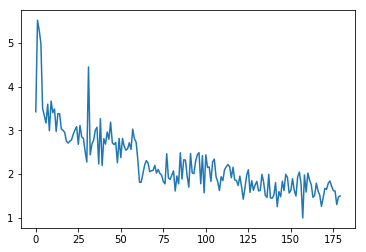

In [6]:
plt.plot(loss_array)

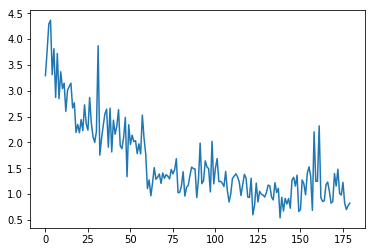

In [3]:
# not reduced weight

plt.plot(loss_array)

In [34]:
img, bbox, label = train_dataset[1995]
img = img.unsqueeze(0).to(device)

conf_pred, loc_pred = model(img)

prior_box = get_prior_box()
iou = get_iou(bbox, prior_box)

pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)

cls = F.softmax(conf_pred[0][pos_mask])

/home/kindeqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [35]:
cls.max(dim=1)

(tensor([0.267, 0.632, 0.477, 0.519, 0.741, 0.375, 0.309, 0.258, 0.316, 0.328,
         0.567, 0.619, 0.592, 0.674, 0.699, 0.736, 0.752, 0.752, 0.771, 0.767,
         0.784, 0.771, 0.790, 0.760, 0.735, 0.791, 0.797, 0.840, 0.841, 0.854,
         0.856, 0.862, 0.864, 0.853, 0.860, 0.830, 0.812, 0.813, 0.861, 0.858,
         0.873, 0.873, 0.875, 0.877, 0.860, 0.869, 0.946, 0.974, 0.957, 0.990,
         0.811, 0.899, 0.983, 0.996, 0.783, 0.920, 0.993, 0.998, 0.689, 0.892,
         0.994, 0.997, 0.987, 0.992, 0.878, 0.950, 0.893, 0.958],
        device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([14,  3, 14, 14,  4, 15, 15,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        device='cuda:0'))

In [36]:
cls_target[pos_mask]

tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       dtype=torch.int32)

In [39]:
model.base_net[12].weight.shape

torch.Size([256, 256, 3, 3])

In [40]:
model_20 = get_SSD_model(1, vgg_weight_path)
model_20.load_state_dict(torch.load('100.pth'))

In [41]:
img, bbox, label = train_dataset[0]

In [42]:
img = img.unsqueeze(0)

In [43]:
cls_pred, loc_pred = model_20(img)

In [44]:
prior_box = get_prior_box()
iou = get_iou(bbox, prior_box)

pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)

In [45]:
pred = cls_pred[0][pos_mask]

In [46]:
cls_target[pos_mask]

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7], dtype=torch.int32)

In [47]:
F.softmax(pred)

/home/kindeqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[7.446e-01, 3.591e-04, 1.342e-03, 1.275e-02, 2.664e-03, 1.323e-03,
         1.368e-04, 1.786e-03, 2.293e-03, 6.282e-03, 1.915e-03, 1.188e-04,
         2.109e-02, 6.637e-03, 1.521e-03, 1.833e-01, 2.602e-03, 6.436e-04,
         2.065e-03, 1.601e-03, 4.908e-03],
        [7.446e-01, 3.591e-04, 1.342e-03, 1.275e-02, 2.664e-03, 1.323e-03,
         1.368e-04, 1.786e-03, 2.293e-03, 6.282e-03, 1.915e-03, 1.188e-04,
         2.109e-02, 6.637e-03, 1.521e-03, 1.833e-01, 2.602e-03, 6.436e-04,
         2.065e-03, 1.601e-03, 4.908e-03],
        [7.446e-01, 3.591e-04, 1.342e-03, 1.275e-02, 2.664e-03, 1.323e-03,
         1.368e-04, 1.786e-03, 2.293e-03, 6.282e-03, 1.915e-03, 1.188e-04,
         2.109e-02, 6.637e-03, 1.521e-03, 1.833e-01, 2.602e-03, 6.436e-04,
         2.065e-03, 1.601e-03, 4.908e-03],
        [7.446e-01, 3.591e-04, 1.342e-03, 1.275e-02, 2.664e-03, 1.323e-03,
         1.368e-04, 1.786e-03, 2.293e-03, 6.282e-03, 1.915e-03, 1.188e-04,
         2.109e-02, 6.637e-03, 1.521e-03, 1.83

In [48]:
bbox_target[pos_mask]

tensor([[ 4.767,  6.817,  1.074, -0.955],
        [ 4.767,  7.649,  1.074, -0.955],
        [ 4.767,  8.065,  1.074, -0.955],
        [ 5.599,  3.072,  1.074, -0.955],
        [ 5.599,  3.488,  1.074, -0.955],
        [ 5.599,  4.320,  1.074, -0.955],
        [ 6.431, -1.089,  1.074, -0.955],
        [ 6.431, -0.257,  1.074, -0.955],
        [ 6.431,  0.159,  1.074, -0.955],
        [ 7.263, -4.834,  1.074, -0.955],
        [ 7.263, -4.418,  1.074, -0.955],
        [ 7.263, -3.585,  1.074, -0.955],
        [ 7.263,  6.817,  1.074, -0.955],
        [ 7.263,  7.649,  1.074, -0.955],
        [ 7.263,  8.065,  1.074, -0.955],
        [ 9.260,  1.992, -0.656,  0.781],
        [11.186,  3.829,  0.289,  1.726],
        [ 9.260,  3.169, -0.656,  0.781],
        [ 9.623,  1.647, -0.464, -2.493],
        [11.186, 13.075,  0.289,  1.726],
        [ 9.260, 10.823, -0.656,  0.781],
        [11.186, 14.497,  0.289,  1.726],
        [ 9.260, 12.000, -0.656,  0.781],
        [ 9.623,  6.235, -0.464, -

In [49]:
loc_pred[0][pos_mask]

tensor([[ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 5.631e+00,  7.717e-01,  2.746e-01,  2.131e-03],
        [ 9.183e+00,  1.652e+00,  7.651e-01,  9.103e-01],
        [ 1.106e+01,  1.067e+00, -4.055e-01,  6.250e-01],
        [ 9.18

In [14]:
s = slice(None, 20, None)

In [16]:
for i in range(s.start, s.stop):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
